In [1]:
import pandas as pd 
import numpy as np

import tensorflow
import keras
from keras import layers, optimizers, regularizers
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.models import Sequential

from keras.utils import plot_model

import keras.backend as K

import seaborn as sns

from sklearn import preprocessing, model_selection 

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

## Data preparation

In [2]:
#read data
student = pd.read_csv("student-por.csv",sep=";")

In [3]:
#rename attributes
student.columns = ['school','sex','age','address','family_size','parents_status','mother_education','father_education',
           'mother_job','father_job','reason','guardian','commute_time','study_time','failures','school_support',
          'family_support','paid_classes','activities','nursery','desire_higher_edu','internet','romantic','family_quality',
          'free_time','go_out','weekday_alcohol_usage','weekend_alcohol_usage','health','absences','period1_score','period2_score','final_score']

In [4]:
# convert final_score to categorical variable # Good:15~20 Fair:10~14 Poor:0~9
student['final_grade'] = 'na'
student.loc[(student.final_score >= 15) & (student.final_score <= 20), 'final_grade'] = 'good' 
student.loc[(student.final_score >= 10) & (student.final_score <= 14), 'final_grade'] = 'fair' 
student.loc[(student.final_score >= 0) & (student.final_score <= 9), 'final_grade'] = 'poor' 
student.head(5)

,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,...,free_time,go_out,weekday_alcohol_usage,weekend_alcohol_usage,health,absences,period1_score,period2_score,final_score,final_grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,4,0,11,11,fair
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,2,9,11,11,fair
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,6,12,13,12,fair
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,0,14,14,14,fair
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,0,11,13,13,fair


In [5]:
data = student
data = data.drop(['final_score'], axis=1)

# label encode final_grade
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data.final_grade = le.fit_transform(data.final_grade)
data.tail(5)

,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,...,family_quality,free_time,go_out,weekday_alcohol_usage,weekend_alcohol_usage,health,absences,period1_score,period2_score,final_grade
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,0
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,1
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,2
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,0
648,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,4,10,11,0


In [6]:
#normalization
def normalization(X):
    mean = np.mean(X)
    std = np.std(X)
    X_t = (X - mean)/std
    return X_t

#Train and Test splitting of data     
def train_test(X_t, y):
    x_train, x_test, y_train, y_test = train_test_split(X_t, y, test_size = 0.3, random_state = 42)
    print("Train:",len(x_train), " - Test:", len(x_test))
    return x_train, x_test, y_train, y_test

In [7]:
# dataset train_test_split
X = data.drop('final_grade',axis=1)

In [8]:
X_t = normalization(X)
print("X_t:", X_t.shape)

#delete the columns with NAN value
X = X_t
X=X.dropna(axis=1,how='all')

X_t: (649, 32)


C:\Users\12619\anaconda3\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:3417: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\12619\anaconda3\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:3558: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [9]:
#normalize the data type
data["final_grade"] =data["final_grade"].astype(object)

In [10]:
data["final_grade"] =data["final_grade"].astype(int)
data = pd.get_dummies(data, columns=["final_grade"])

In [11]:
Y = data.iloc[:,32:].values

In [12]:
X = preprocessing.normalize(X, axis = 0)

X_train,X_test,Y_train,Y_test = model_selection.train_test_split(X,Y,test_size=0.3)

print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(454, 15) (454, 3) (195, 15) (195, 3)


## Build neutral networks
choose model with different numbers of layer

In [13]:
winemod1 = Sequential()
# layer 1
winemod1.add(Dense(30, input_dim=15, activation='relu', name='fc0',kernel_regularizer=regularizers.l2(0.01)))
winemod1.add(BatchNormalization(momentum=0.99, epsilon=0.001))
#layer 2
winemod1.add(Dense(50, name='fc1',bias_initializer='zeros'))
winemod1.add(BatchNormalization(momentum=0.99, epsilon=0.001))
winemod1.add(Activation('tanh'))
winemod1.add(Dropout(0.5))
#layer 3
winemod1.add(Dense(100, name='fc2',bias_initializer='zeros'))
winemod1.add(BatchNormalization(momentum=0.99, epsilon=0.001))
winemod1.add(Activation('relu'))
winemod1.add(Dropout(0.5))
#layer 4
winemod1.add(Dense(3, name='fc3',bias_initializer='zeros'))
winemod1.add(BatchNormalization(momentum=0.99, epsilon=0.001))
winemod1.add(Activation('softmax'))

In [14]:
winemod1 = Sequential()
# layer 1
winemod1.add(Dense(30, input_dim=15, activation='relu', name='fc0',kernel_regularizer=regularizers.l2(0.01)))
winemod1.add(BatchNormalization(momentum=0.99, epsilon=0.001))
#layer 2
winemod1.add(Dense(50, name='fc1',bias_initializer='zeros'))
winemod1.add(BatchNormalization(momentum=0.99, epsilon=0.001))
winemod1.add(Activation('tanh'))
winemod1.add(Dropout(0.5))
#layer 3
winemod1.add(Dense(100, name='fc2',bias_initializer='zeros'))
winemod1.add(BatchNormalization(momentum=0.99, epsilon=0.001))
winemod1.add(Activation('relu'))
winemod1.add(Dropout(0.5))
#layer 4
winemod1.add(Dense(100, name='fc3',bias_initializer='zeros'))
winemod1.add(BatchNormalization(momentum=0.99, epsilon=0.001))
winemod1.add(Activation('relu'))
winemod1.add(Dropout(0.5))
#layer 5
winemod1.add(Dense(3, name='fc4',bias_initializer='zeros'))
winemod1.add(BatchNormalization(momentum=0.99, epsilon=0.001))
winemod1.add(Activation('softmax'))

In [15]:
winemod1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc0 (Dense)                  (None, 30)                480       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30)                120       
_________________________________________________________________
fc1 (Dense)                  (None, 50)                1550      
_________________________________________________________________
batch_normalization_5 (Batch (None, 50)                200       
_________________________________________________________________
activation_3 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
fc2 (Dense)                  (None, 100)              

In [16]:
Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
winemod1.compile(optimizer = Adam,loss = "categorical_crossentropy", metrics = ["categorical_accuracy"])

C:\Users\12619\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [17]:
history = winemod1.fit(x = X_train, y = Y_train, epochs = 40,verbose=1, batch_size = 64,validation_data=(X_test, Y_test))

Epoch 1/40
8/8 [==============================] - 1s 43ms/step - loss: 1.5559 - categorical_accuracy: 0.3524 - val_loss: 1.2859 - val_categorical_accuracy: 0.5846
Epoch 2/40
8/8 [==============================] - 0s 6ms/step - loss: 1.5077 - categorical_accuracy: 0.3480 - val_loss: 1.2769 - val_categorical_accuracy: 0.6205
Epoch 3/40
8/8 [==============================] - 0s 6ms/step - loss: 1.4512 - categorical_accuracy: 0.3568 - val_loss: 1.2727 - val_categorical_accuracy: 0.6205
Epoch 4/40
8/8 [==============================] - 0s 6ms/step - loss: 1.4027 - categorical_accuracy: 0.4097 - val_loss: 1.2708 - val_categorical_accuracy: 0.6513
Epoch 5/40
8/8 [==============================] - 0s 6ms/step - loss: 1.3454 - categorical_accuracy: 0.4339 - val_loss: 1.2669 - val_categorical_accuracy: 0.6615
Epoch 6/40
8/8 [==============================] - 0s 6ms/step - loss: 1.3462 - categorical_accuracy: 0.4581 - val_loss: 1.2601 - val_categorical_accuracy: 0.6615
Epoch 7/40
8/8 [===========

## Evaluate 

In [18]:
preds = winemod1.evaluate(x = X_test, y = Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

7/7 [==============================] - 0s 834us/step - loss: 0.9491 - categorical_accuracy: 0.6974

Loss = 0.9491257667541504
Test Accuracy = 0.6974359154701233


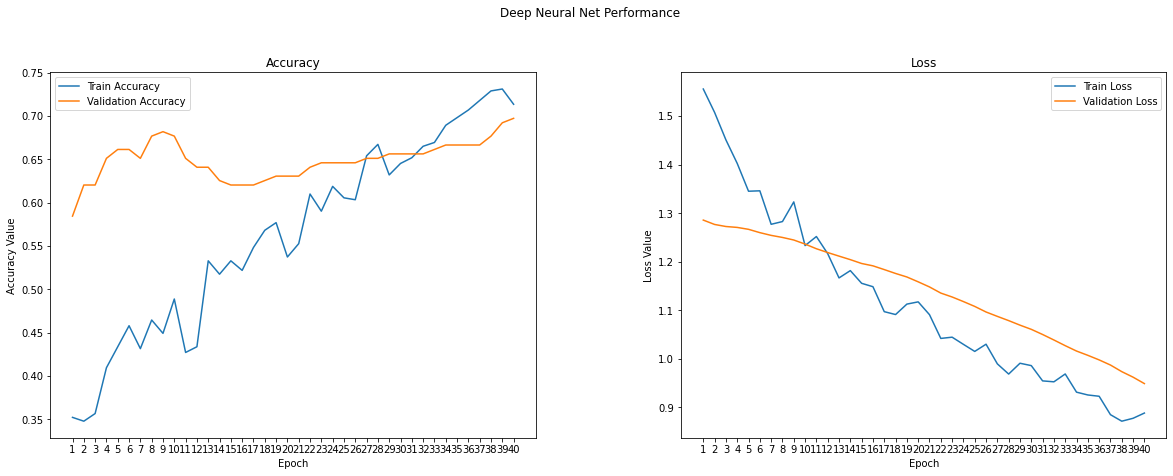

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,41))
ax1.plot(epochs, history.history['categorical_accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_categorical_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")